In [1]:
#import Librerie
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.metrics import homogeneity_score, completeness_score, v_measure_score
from sklearn.preprocessing import StandardScaler
from mpl_toolkits.mplot3d import Axes3D  


from utils.utils_functions import Utils_functions

In [2]:
X, y = Utils_functions.load_data()

#faccio 4 procedimenti complementari, uno con i dati raw, uno con i dati normalizzati, uno con i dati standardizzati e uno con le componenti principali estratte tramite la pca, durante l'esplorazione del 
#dataset abbiamo notato come il 90% della varianza viene spiegato dalle prime 7 componenti.

#preprocesso i dati
datasets, datasets_names, pca_components = Utils_functions.X(X)

Numero di componenti necessarie per spiegare almeno il 90.0% della varianza: 7


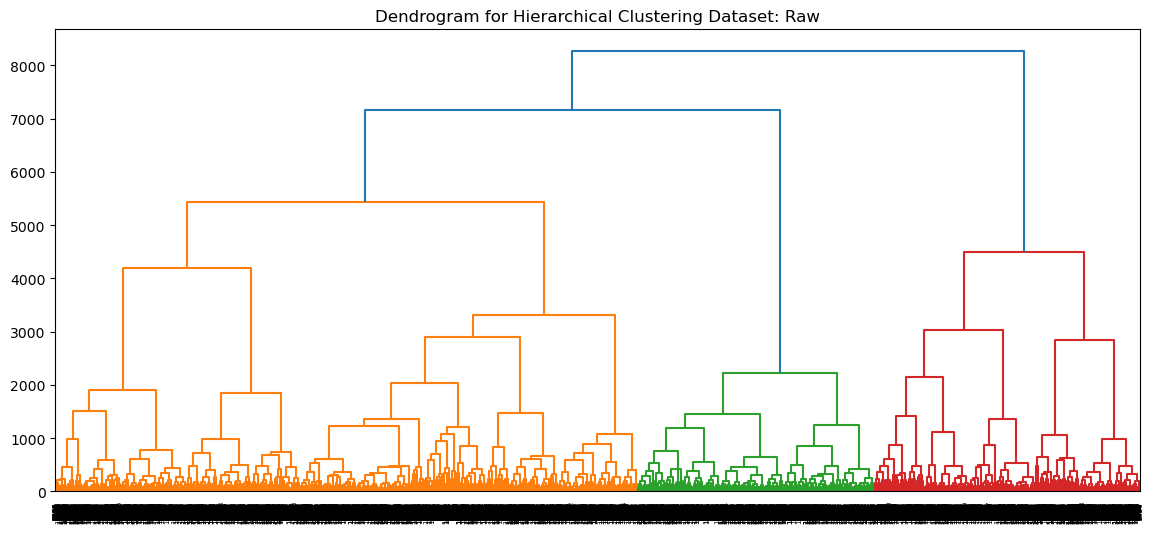

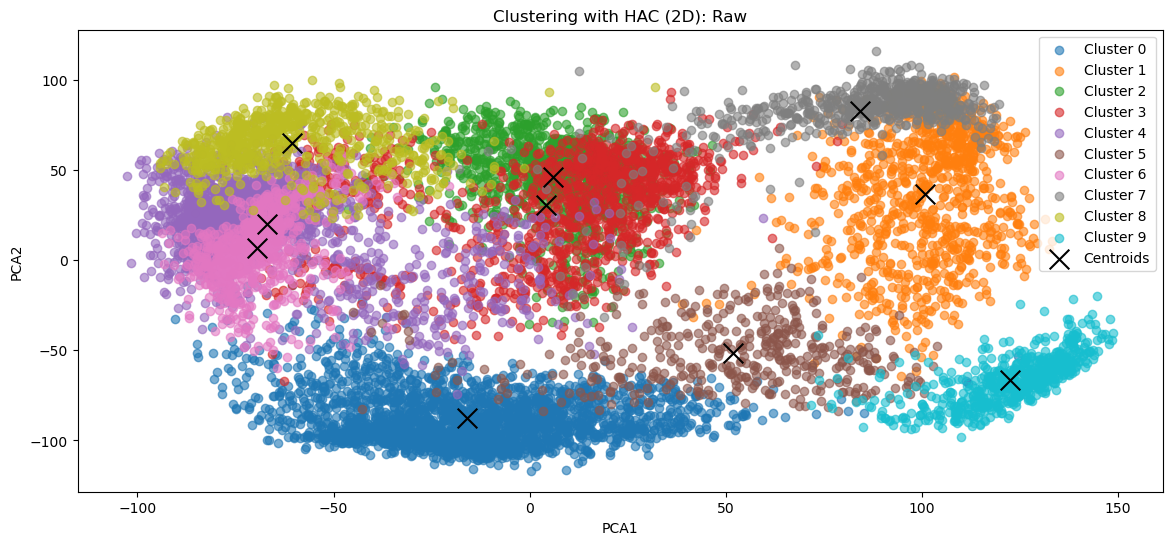

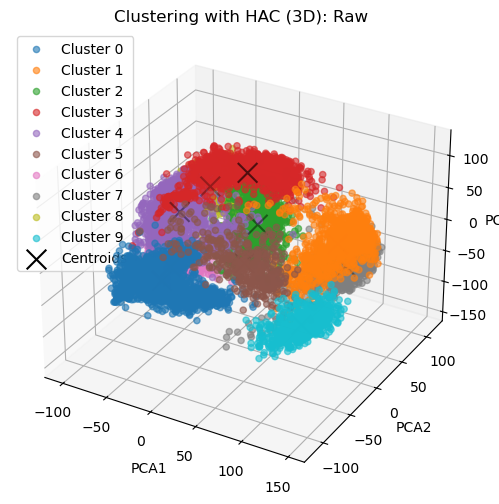

Metriche con Dataset: Raw
ARI: 0.5532013764147102
NMI: 0.7281363125930365
Homogeneity: 0.707537034737052
Completeness: 0.749971016057637
V-Measure: 0.7281363125930364
SSE: 51656881.62
MSE: 4699.50





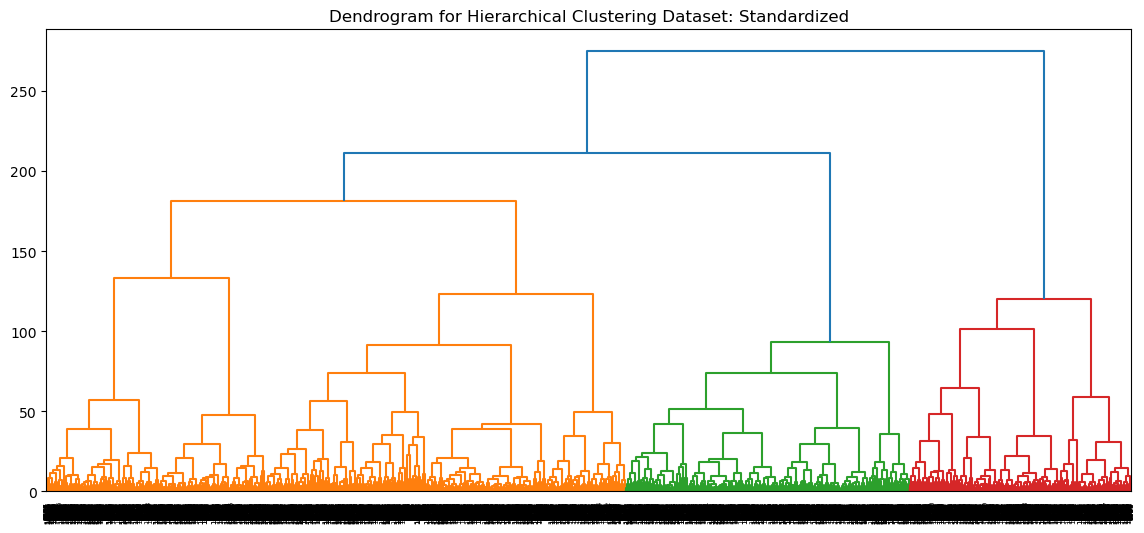

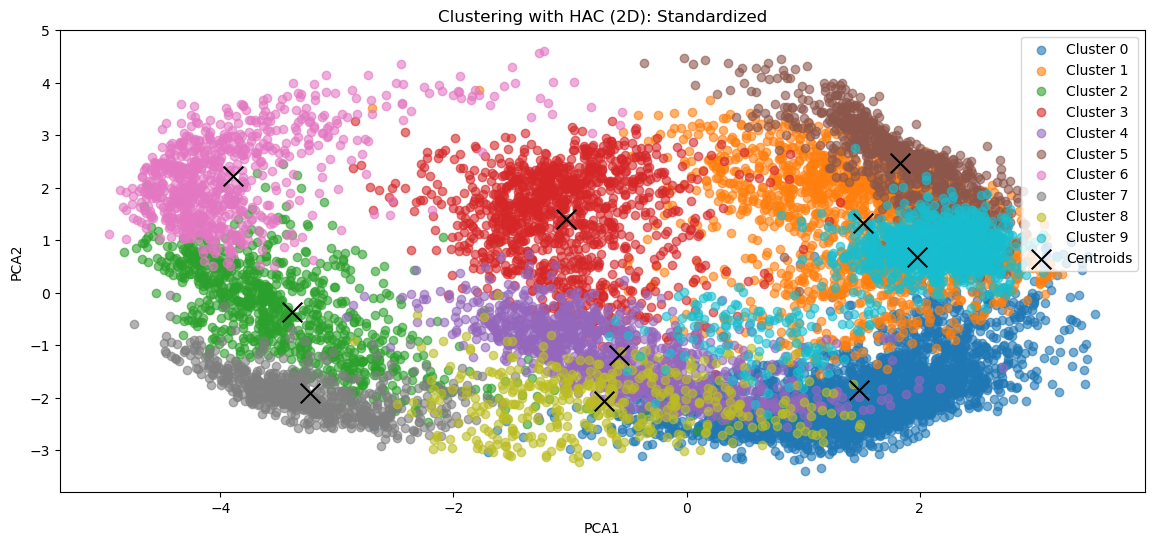

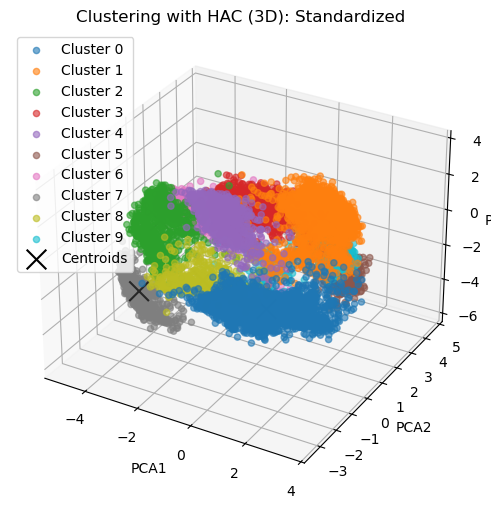

Metriche con Dataset: Standardized
ARI: 0.6103403068918539
NMI: 0.7680806088634107
Homogeneity: 0.7490751614049059
Completeness: 0.7880755701346318
V-Measure: 0.7680806088634106
SSE: 61966.91
MSE: 5.64





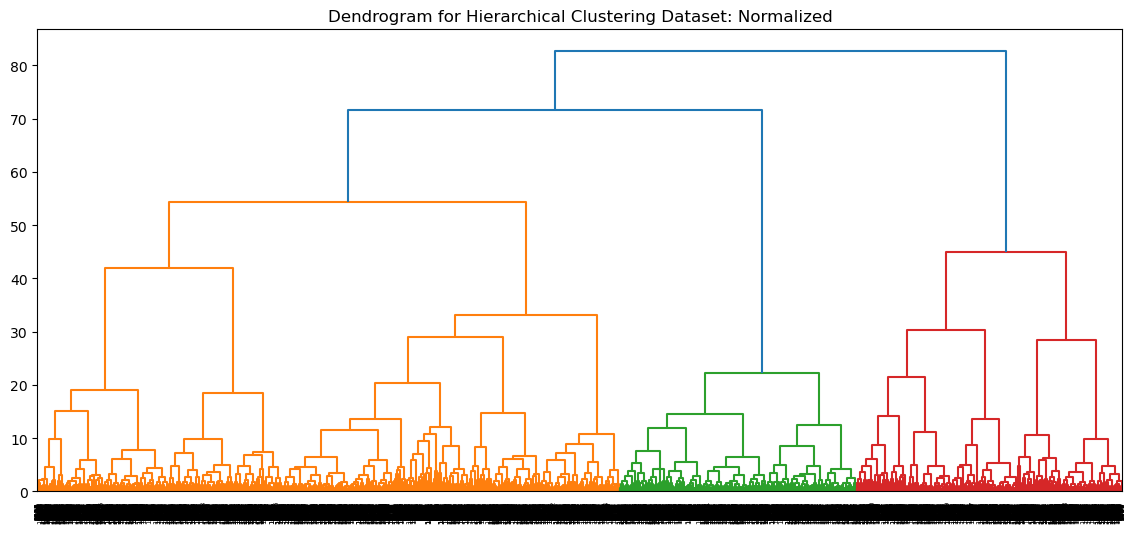

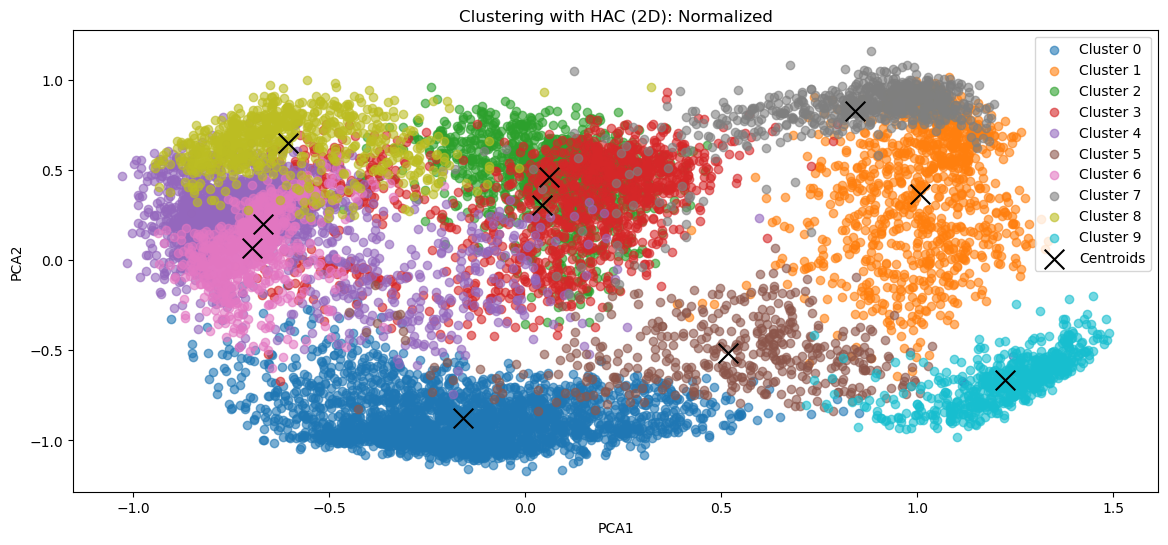

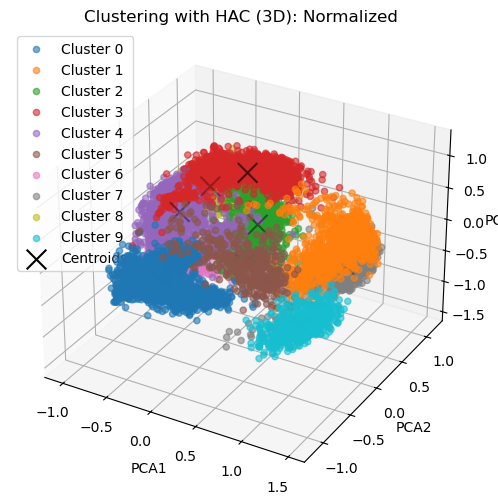

Metriche con Dataset: Normalized
ARI: 0.5532013764147102
NMI: 0.7281363125930365
Homogeneity: 0.707537034737052
Completeness: 0.749971016057637
V-Measure: 0.7281363125930364
SSE: 5165.69
MSE: 0.47





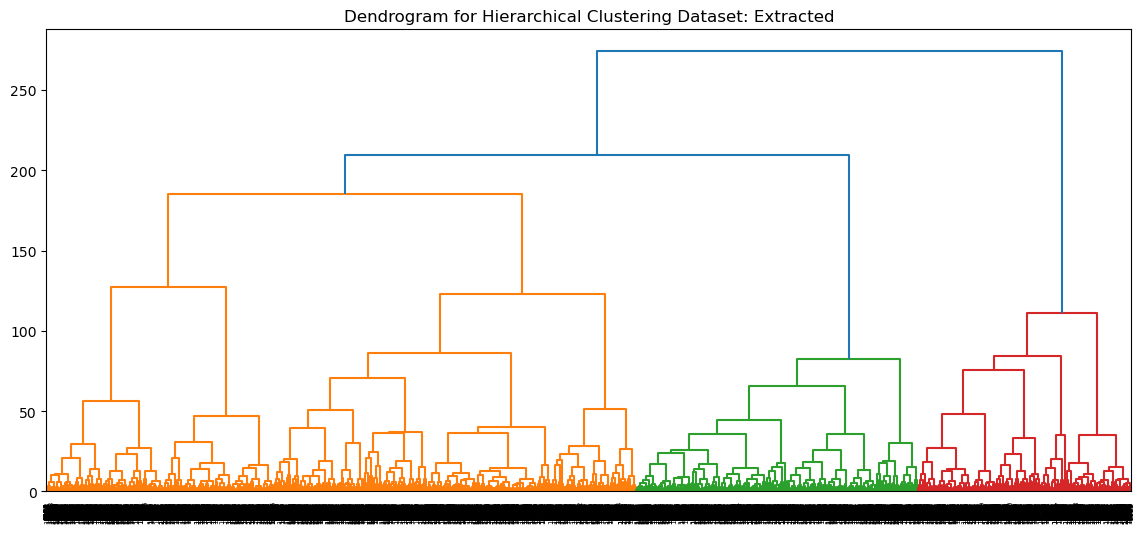

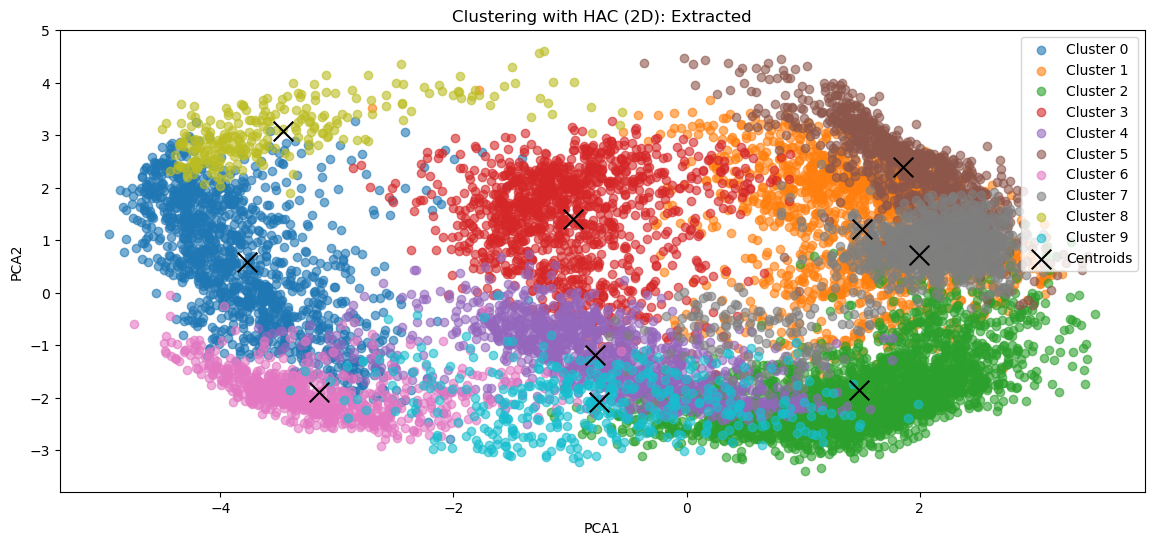

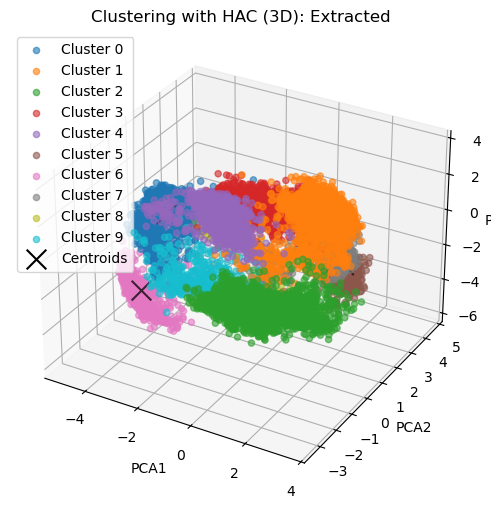

Metriche con Dataset: Extracted
PCA components: 7
ARI: 0.5803861585221083
NMI: 0.7272997958065348
Homogeneity: 0.7050130910883908
Completeness: 0.7510415408369024
V-Measure: 0.7272997958065348
SSE: 47170.97
MSE: 4.29





In [3]:
#colonne per PCA
columns = [f"PCA{i}" for i in range(1, pca_components + 1)]
columns_2d = columns[:2]
columns_3d = columns[:3]

#numero di cluster
num_clusters = 10

#carico il modello di clustering gerarchico
#come numero di cluster scelgo 10, in quanto il dataset è composto da 10 classi (10 cifre 0-9)
#linkage: criterio di collegamento, ward minimizza la varianza delle distanze tra i cluster
hierarchical_clustering = AgglomerativeClustering(n_clusters = num_clusters, metric = 'euclidean', linkage = 'ward')

#per ogni dataset eseguo il clustering e prendo labels
for i, X in enumerate(datasets):
    
    #eseguo il clustering
    labels = hierarchical_clustering.fit_predict(X)
    
    #linkage per il dendrogramma
    linked = linkage(X, 'ward')
    
    #riduzione dimensionale per i plot
    if (i < 3):
        #inizializzo la PCA
        pca = PCA(n_components = pca_components)
        
        #addestro lo scaler con il dataset
        reduced_data = pca.fit_transform(X)
        
        #creo il dataframe con i dati ridotti
        df_pca = pd.DataFrame(reduced_data, columns=columns)
          
    else:
        #creo il dataframe con i dati ridotti
        df_pca = pd.DataFrame(X, columns=columns)
    
    
    #aggiungo la colonna con i cluster
    df_pca['Cluster'] = labels

    
    #calcolo i centroidi come media dei punti per ogni cluster
    #per ogni cluster calcolo la media dei punti, prendendo solo i punti del cluster in questione tramite la maschera labels == cluster
    centroids = np.array([df_pca[labels == cluster].mean(axis=0) for cluster in range(num_clusters)])
    
    #plotto il dendrogramma
    plt.figure(figsize=(14, 6))
    dendrogram(linked, orientation='top', distance_sort='descending', show_leaf_counts=False)
    plt.title(f'Dendrogram for Hierarchical Clustering Dataset: {datasets_names[i]}')
    plt.show()
    
    #plot 2D
    plt.figure(figsize=(14, 6))
    
    for cluster in range(num_clusters):
        
        cluster_data = df_pca[df_pca['Cluster'] == cluster]
        plt.scatter(cluster_data[columns_2d[0]],
                    cluster_data[columns_2d[1]],
                    label=f'Cluster {cluster}', alpha=0.6)
    
    #centroidi in 2D
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=200, c='black', label='Centroids')
    plt.title(f'Clustering with HAC (2D): {datasets_names[i]}')
    plt.xlabel(columns_2d[0])
    plt.ylabel(columns_2d[1])
    plt.legend()
    plt.show()
    
    #plot 3D
    if pca_components >= 3:
        
        fig = plt.figure(figsize=(14, 6))
        ax = fig.add_subplot(111, projection='3d')
        
        for cluster in range(num_clusters):
            
            cluster_data = df_pca[df_pca['Cluster'] == cluster]
            ax.scatter(cluster_data[columns_3d[0]],
                       cluster_data[columns_3d[1]],
                       cluster_data[columns_3d[2]],
                       label=f'Cluster {cluster}', alpha=0.6)
            
        #centroidi in 3D
        ax.scatter(centroids[:, 0], centroids[:, 1], centroids[:, 2],
                   marker='x', s=200, c='black', label='Centroids')
        ax.set_title(f'Clustering with HAC (3D): {datasets_names[i]}')
        ax.set_xlabel(columns_3d[0])
        ax.set_ylabel(columns_3d[1])
        ax.set_zlabel(columns_3d[2])
        ax.legend()
        plt.show()

    #calcolo i valori di similarità
    ari = adjusted_rand_score(y, labels)
    nmi = normalized_mutual_info_score(y, labels)
    hom = homogeneity_score(y, labels)
    comp = completeness_score(y, labels)
    vms = v_measure_score(y, labels)

    #calcolo SSE e MSE
    sse = Utils_functions.compute_SSE(X, labels)
    mse = sse / X.shape[0]

    print(f"Metriche con Dataset: {datasets_names[i]}")
    
    if i == 3:
        print(f"PCA components: {pca_components}")
    
    print(f"ARI: {ari}")
    print(f"NMI: {nmi}")
    print(f"Homogeneity: {hom}")
    print(f"Completeness: {comp}")
    print(f"V-Measure: {vms}")
    print(f"SSE: {sse:.2f}")
    print(f"MSE: {mse:.2f}\n")
    print("\n")

Numero ottimale di cluster (Elbow) per Dataset Raw: 6
Numero reale di cluster: 10
Il numero reale di cluster NON coincide con il numero ottimale secondo la regola dell'elbow.


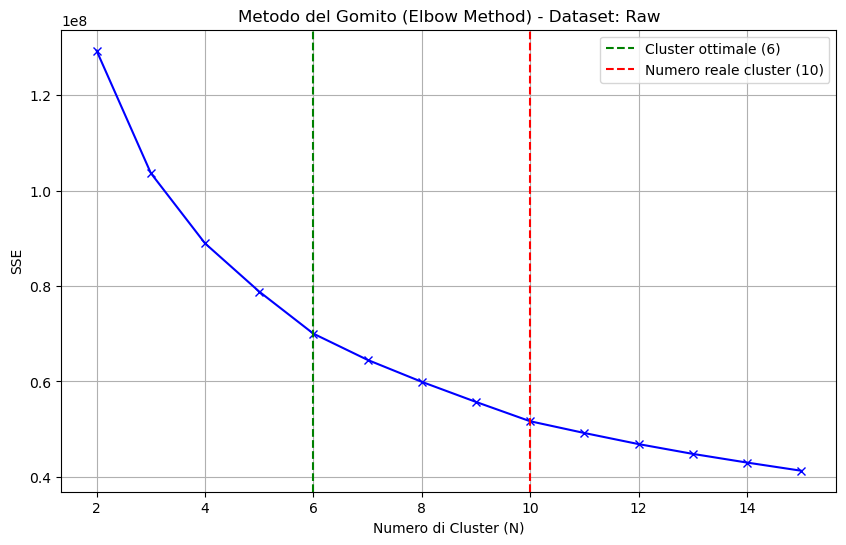

Numero ottimale di cluster (Elbow) per Dataset Standardized: 7
Numero reale di cluster: 10
Il numero reale di cluster NON coincide con il numero ottimale secondo la regola dell'elbow.


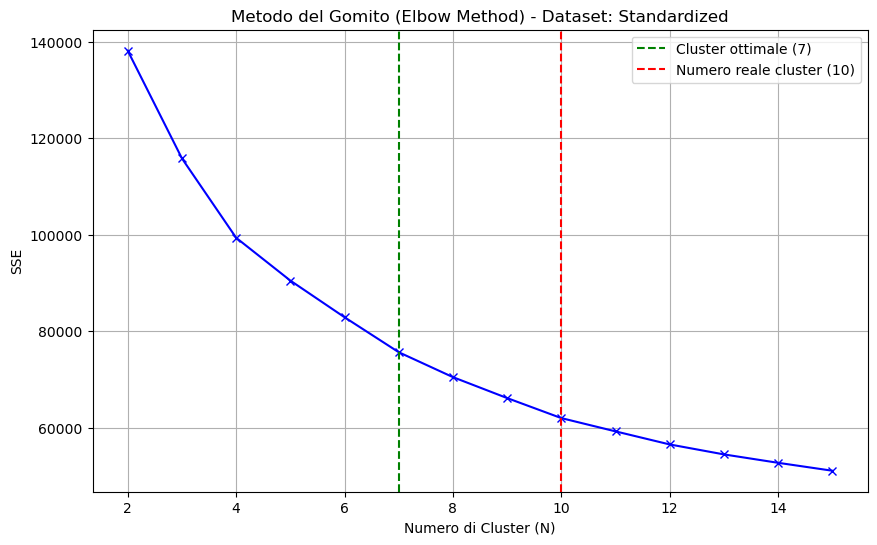

Numero ottimale di cluster (Elbow) per Dataset Normalized: 6
Numero reale di cluster: 10
Il numero reale di cluster NON coincide con il numero ottimale secondo la regola dell'elbow.


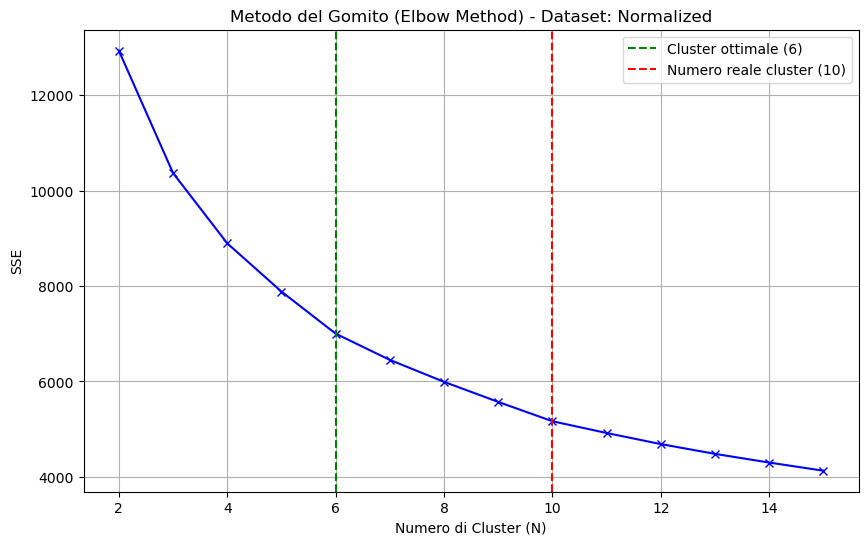

Numero ottimale di cluster (Elbow) per Dataset Extracted: 6
Numero reale di cluster: 10
Il numero reale di cluster NON coincide con il numero ottimale secondo la regola dell'elbow.


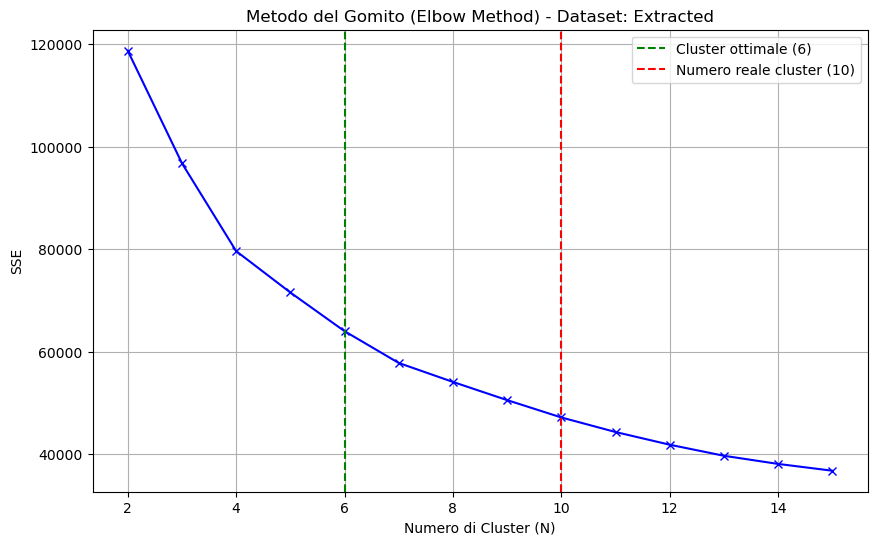

In [4]:
#per ogni dataset calcolo il numero ottimale di cluster tramite il metodo del gomito
#inoltre verifico se il numero di cluster ottimale è compatibile con il numero di classi reale (10)
for i, X in enumerate(datasets):
        #calcolo la variazione dell'sse in base al numero di cluster
        Utils_functions.choose_optimal_clusters_elbow_method(X, datasets_names[i])